# A qualitative example of Recurrence for Time Series Classification


In [1]:
import sys
import os

# get the files if executed in colab
if not os.path.exists("requirements.txt"):
  !git clone https://github.com/MarcCoru/phiweek19 /tmp/repo
  !mv /tmp/repo/* .

!pip install -r requirements.txt

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from rnn import RNN
import torch
import torch.nn.functional as F
import tqdm
from torch import matmul, sigmoid, tanh

sns.set_style("whitegrid")

BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9']

# simulate no GPU (for checks like torch.cuda.is_available())
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Data

### Data Partitioning

The models were trained on the trainset of the HOLL region.
This notebook loads data exclusively from test partitions of the HOLL region and a spatially different KRUM region. Change the parameter `region=holl` to `region=krum` to change the data region

In [2]:
# Test Partition of the HOLL region (model was trained on the Train Partition on the HOLL region)
region = "holl" # <- change to 'krum' for test data from a different region

if region == "holl":
    X = np.load("data/x.npy")
    Y = np.load("data/y.npy")
    meta = np.load("data/meta.npy")
elif region == "krum":
    # Test Partition of the KRUM region
    X = np.load("data/x_krum.npy")
    Y = np.load("data/y_krum.npy")
    meta = np.load("data/meta_krum.npy")

print(f"X shape: (N, T, D):{X.shape} with N examples, sequencelength T, and D number of features per t")
print(f"y shape: (N, C):{Y.shape} with N examples, sequencelength T (class repeatet T times)")

klassennamen = np.load("data/classnames.npy", allow_pickle=True)
classnames = klassennamen

X shape: (N, T, D):(100, 50, 13) with N examples, sequencelength T, and D number of features per t
y shape: (N, C):(100, 50) with N examples, sequencelength T (class repeatet T times)


## Initialize the model and load pre-trained weights

In [3]:
model = RNN(input_dim=13, nclasses=33, hidden_dims=32,
                      num_rnn_layers=4, dropout=0.710883, bidirectional=True)
model.load("rnn.pth")
model.eval()

loading model from rnn.pth


RNN(
  (inlayernorm): LayerNorm(torch.Size([13]), eps=1e-05, elementwise_affine=True)
  (clayernorm): LayerNorm(torch.Size([256]), eps=1e-05, elementwise_affine=True)
  (lstm): LSTM(13, 32, num_layers=4, bias=False, batch_first=True, dropout=0.710883, bidirectional=True)
  (linear_class): Linear(in_features=256, out_features=33, bias=True)
)

## Chose one Example for the Analysis

In [4]:
idx = 5 # <- change this to an index between 0 and N=99

x = X[idx]
y = Y[idx,0]
x = torch.from_numpy(x)

logprobabilities = model.forward(x[None,:,:])

## Get the weights from the model's first layer and split up for respective gates

In [5]:
# get weight tensors of the first layer forward pass (l0)
weight_hh = model.lstm.weight_hh_l0
weight_ih = model.lstm.weight_ih_l0

w_ii, w_if, w_ig, w_io = weight_ih.chunk(4, 0)
w_hi, w_hf, w_hg, w_ho = weight_hh.chunk(4, 0)

w_i = torch.cat([w_ii,w_hi],dim=1)
w_f = torch.cat([w_if,w_hf],dim=1)
w_g = torch.cat([w_ig,w_hg],dim=1)
w_o = torch.cat([w_io,w_ho],dim=1)

## Visualize the weights of the first recurrent layer

[None, None, None, None, None, None, None, None]

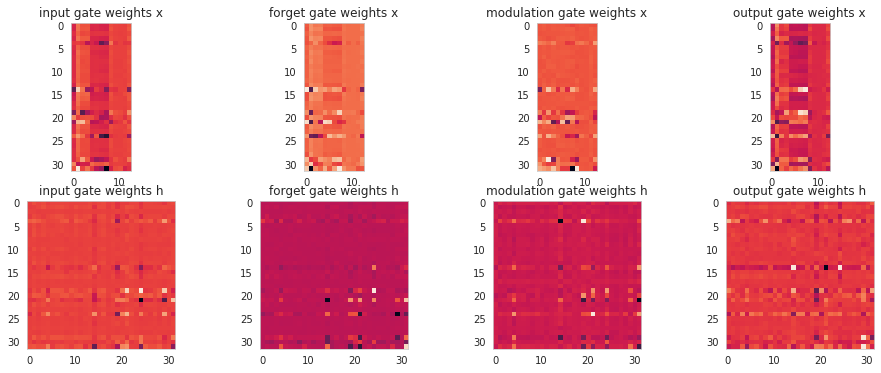

In [6]:
fix, axs = plt.subplots(2,4, figsize=(16,6))
axs[0,0].imshow(w_ii.detach().numpy())
axs[0,0].set_title("input gate weights x")
axs[0,1].imshow(w_if.detach().numpy())
axs[0,1].set_title("forget gate weights x")
axs[0,2].imshow(w_ig.detach().numpy())
axs[0,2].set_title("modulation gate weights x")
axs[0,3].imshow(w_io.detach().numpy())
axs[0,3].set_title("output gate weights x")
axs[1,0].imshow(w_hi.detach().numpy())
axs[1,0].set_title("input gate weights h")
axs[1,1].imshow(w_hf.detach().numpy())
axs[1,1].set_title("forget gate weights h")
axs[1,2].imshow(w_hg.detach().numpy())
axs[1,2].set_title("modulation gate weights h")
axs[1,3].imshow(w_ho.detach().numpy())
axs[1,3].set_title("output gate weights h")

[ax.grid(False) for ax in axs.reshape(-1)]

## Re-implement the LSTM update

In pytorch, the LSTM loop is optimized away. We have access to the weights and input output features.
so, we can re-implement the LSTM cell state update

In [7]:
# for later plotting
i_all = list()
f_all = list()
g_all = list()
o_all = list()
h_all = list()
c_all = list()

h_prev = torch.zeros(32)
c_prev = torch.zeros(32)

for t in range(x.shape[0]):
    
    # append previous information t-1 with current information
    xh = torch.cat([x[t,:],h_prev])

    i = sigmoid(matmul(w_i, xh))
    f = sigmoid(matmul(w_f, xh))
    g = tanh(matmul(w_g, xh))
    o = sigmoid(matmul(w_o, xh))
    
    c = f*c_prev + i*g
    h = o*tanh(c)
    
    # update c, h for next iteration
    h_prev = h
    c_prev = c

    # store gates for later plotting
    i_all.append(i)
    f_all.append(f)
    g_all.append(g)
    o_all.append(o)
    h_all.append(h)
    c_all.append(c)
    
i_all = torch.stack(i_all)
f_all = torch.stack(f_all)
g_all = torch.stack(g_all)
o_all = torch.stack(o_all)
h_all = torch.stack(h_all)
c_all = torch.stack(c_all)

## Visualize the Gate Activations when doing inference on a time series

writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/5/x.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/5/i.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/5/f.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/5/o.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/5/g.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/5/h.csv
writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/5/c.csv


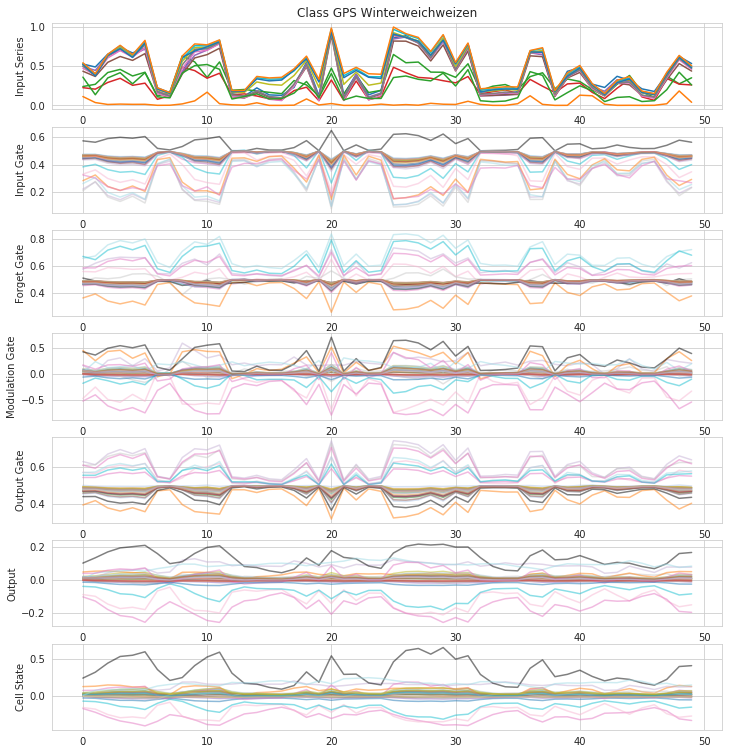

In [8]:
import matplotlib.pylab as pl

hidden_dims = 32

colors = pl.cm.tab20(np.linspace(0,1,hidden_dims))

# positive spike for clouds
colors[30] = np.array([0,0,0,0])

fig, axs = plt.subplots(7,1, figsize=(12,13))

# randomize the sequence in which the lines are plotted (on top of each other...)
plotting_idxs = np.arange(hidden_dims)
np.random.shuffle(plotting_idxs)

axs[0].plot(x.detach().numpy())
axs[0].set_ylabel("Input Series")
axs[0].set_title("Class {}".format(classnames[y]))
[axs[1].plot(i_all[:,i].detach().numpy(), color=colors[i], alpha=0.5) for i in plotting_idxs]
axs[1].set_ylabel("Input Gate")
[axs[2].plot(f_all[:,i].detach().numpy(), color=colors[i], alpha=0.5) for i in plotting_idxs]
axs[2].set_ylabel("Forget Gate")
[axs[3].plot(g_all[:,i].detach().numpy(), color=colors[i], alpha=0.5) for i in plotting_idxs]
axs[3].set_ylabel("Modulation Gate")
[axs[4].plot(o_all[:,i].detach().numpy(), color=colors[i], alpha=0.5) for i in plotting_idxs]
axs[4].set_ylabel("Output Gate")
[axs[5].plot(h_all[:,i].detach().numpy(), color=colors[i], alpha=0.5) for i in plotting_idxs]
axs[5].set_ylabel("Output")
[axs[6].plot(c_all[:,i].detach().numpy(), color=colors[i], alpha=0.5, label="hidden dim {}".format(i)) for i in range(hidden_dims)]
axs[6].set_ylabel("Cell State")
#axs[7].legend()

path="/home/marc/projects/Phiweek19_Presentation/images/rnn_examples"

import pandas as pd
os.makedirs(os.path.join(path,str(idx)), exist_ok=True)

df = pd.DataFrame(x.detach().numpy(), columns=BANDS)
df.index.name="t"
df.to_csv(os.path.join(path,str(idx),"x.csv"))
print("writing: "+os.path.join(path,str(idx),"x.csv"))

for name, tensor in zip(["i","f","o","g","h","c"],[i_all,f_all,o_all,g_all,h_all,c_all]):
    df = pd.DataFrame(tensor.detach().numpy())
    df.index.name="t"
    df.to_csv(os.path.join(path,str(idx),name+".csv"))
    print("writing: "+os.path.join(path,str(idx),name+".csv"))

## Gradients can be used to analyze the input feature importance


![](doc/grad_explained.png)


## Do Forward Inference and Gradient Backpropagation

1. Add gradients to the input `x_` (new variable with gradients)
2. do forward inference
3. get the scalar with the highest prediction score: `logprobabilities.exp().max()`
4. do gradient backpropagation `.backward()` (to all variables with gradients)
5. retrieve the gradients with `.grad`

In [9]:
x_ = torch.autograd.Variable(x[None,:,:], requires_grad=True)
logprobabilities = model.forward(x_)
maxypred = logprobabilities.exp().max()
maxypred.backward()
dydx = x_.grad

## Visualize Gradients along with input time series

writing: /home/marc/projects/Phiweek19_Presentation/images/rnn_examples/5/dydx.csv


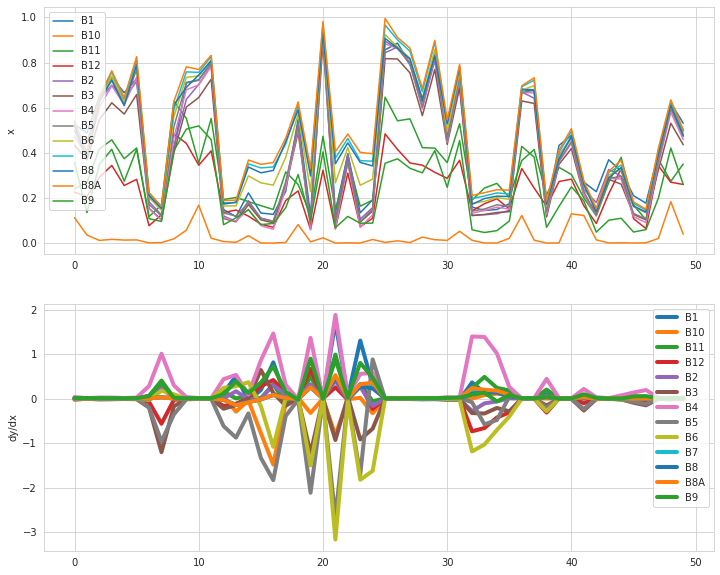

In [10]:
fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(x_[0].detach().numpy())
axs[0].set_ylabel("x")
axs[0].legend(BANDS)
axs[1].plot(x_.grad[0].numpy(),linewidth=4)
axs[1].set_ylabel("dy/dx")
axs[1].legend(BANDS)

df = pd.DataFrame(x_.grad[0].numpy(), columns=BANDS)
df.index.name="t"
df.to_csv(os.path.join(path,str(idx),"dydx.csv"))
print("writing: "+os.path.join(path,str(idx),"dydx.csv"))

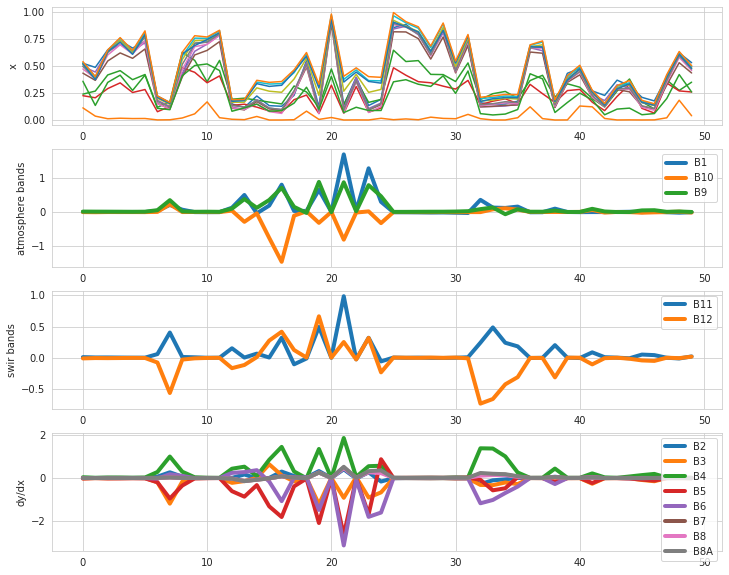

In [11]:
fig, axs = plt.subplots(4, figsize=(12,10))
axs[0].plot(x_[0].detach().numpy())
axs[0].set_ylabel("x")
axs[1].plot(x_.grad[0,:,[0,1,12]].numpy(),linewidth=4)
axs[1].set_ylabel("atmosphere bands")
axs[1].legend(np.array(BANDS)[[0,1,12]])
axs[2].plot(x_.grad[0,:,[2,3]].numpy(),linewidth=4)
axs[2].legend(np.array(BANDS)[[2,3]])
axs[2].set_ylabel("swir bands")
axs[3].plot(x_.grad[0,:,4:12].numpy(),linewidth=4)
axs[3].set_ylabel("dy/dx")
axs[3].legend(np.array(BANDS)[4:12])

### A PGF/Tikzed example of idx=5 (Holl region)

![](doc/grad_result.png)

## Get the Gradients on the weights

In [12]:
dweight_hh = model.lstm.weight_hh_l0.grad
dweight_ih = model.lstm.weight_ih_l0.grad

dw_ii, dw_if, dw_ig, dw_io = weight_ih.chunk(4, 0)
dw_hi, dw_hf, dw_hg, dw_ho = weight_hh.chunk(4, 0)

dw_i = torch.cat([w_ii,w_hi],dim=1)
dw_f = torch.cat([w_if,w_hf],dim=1)
dw_g = torch.cat([w_ig,w_hg],dim=1)
dw_o = torch.cat([w_io,w_ho],dim=1)

## Visualize

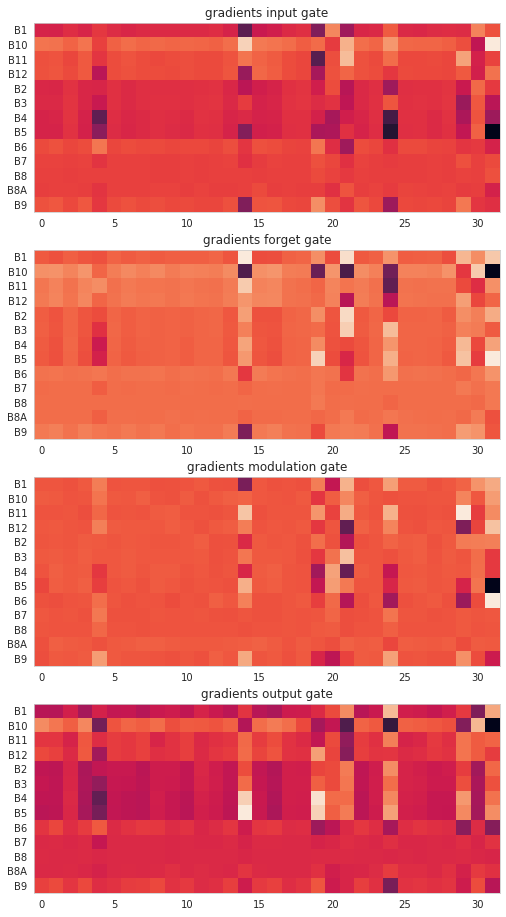

In [13]:
fix, axs = plt.subplots(4, figsize=(16,16))
axs[0].imshow(dw_ii.detach().numpy().T)
axs[1].imshow(dw_if.detach().numpy().T)
axs[2].imshow(dw_ig.detach().numpy().T)
axs[3].imshow(dw_io.detach().numpy().T)

for ax, name in zip(axs.reshape(-1),["input","forget","modulation", "output"]):
    ax.set_yticks(np.arange(len(BANDS)))
    ax.set_yticklabels(BANDS)
    ax.set_title("gradients " + name + " gate")
    ax.grid(False)

## Values Gates

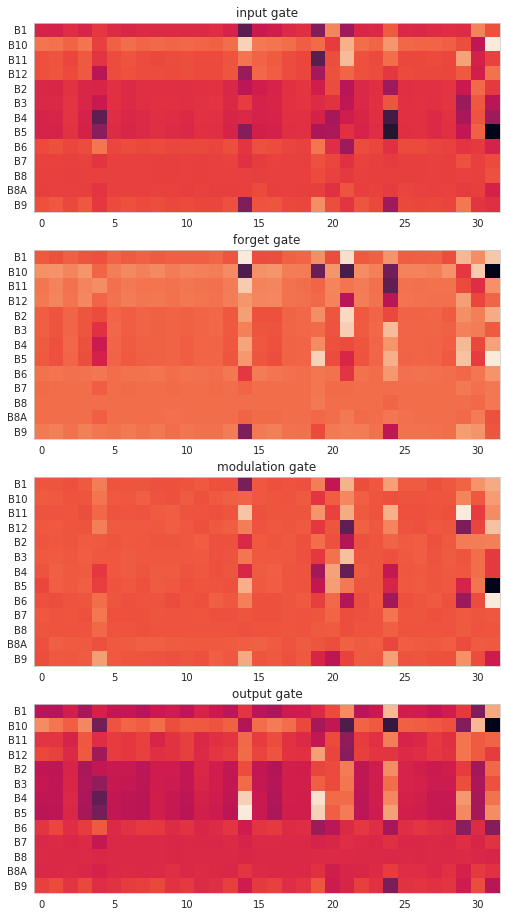

In [14]:
fix, axs = plt.subplots(4, figsize=(16,16))
axs[0].imshow(w_ii.detach().numpy().T)
axs[1].imshow(w_if.detach().numpy().T)
axs[2].imshow(w_ig.detach().numpy().T)
axs[3].imshow(w_io.detach().numpy().T)

for ax, name in zip(axs.reshape(-1),["input","forget","modulation", "output"]):
    ax.set_yticks(np.arange(len(BANDS)))
    ax.set_yticklabels(BANDS)
    ax.set_title(name + " gate")
    ax.grid(False)